In [1]:
!pip install torchviz

GPU is available and being used.
Loading dataset in chunks...
Combining processed chunks...
Preparing features and target...
Splitting data into train and validation sets...
Building LSTM model...
Model visualization saved as 'lstm_model.png'
Starting model training...
Epoch 1/10
Validation Loss: 0.7989943773354115
Epoch 2/10
Validation Loss: 0.754242051674233
Epoch 3/10
Validation Loss: 0.7116631804654934
Epoch 4/10
Validation Loss: 0.6856572491846278
Epoch 5/10
Validation Loss: 0.6402051800922939
Epoch 6/10
Validation Loss: 0.6313665517227688
Epoch 7/10
Validation Loss: 0.6104810541455831
Epoch 8/10
Validation Loss: 0.616631588731423
Epoch 9/10
Validation Loss: 0.5654691963290377
Epoch 10/10
Validation Loss: 0.5512533151500151
Model training complete.


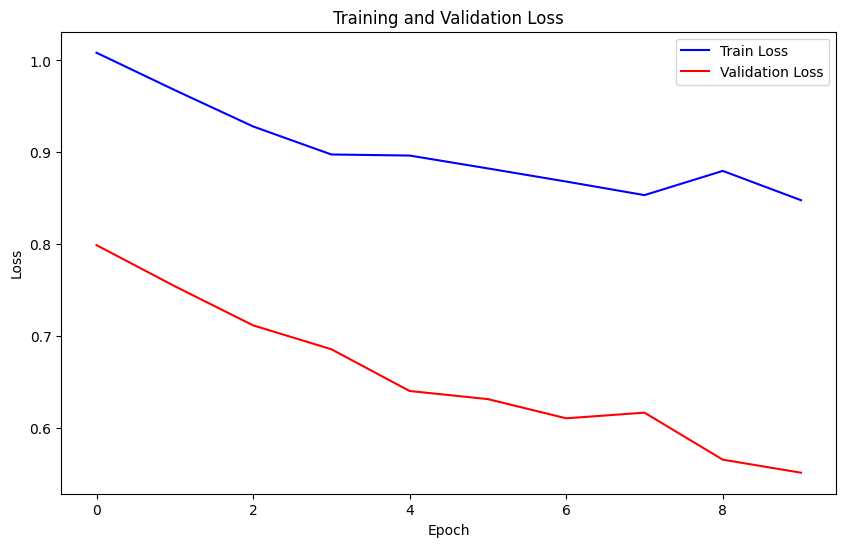

Saving the model...
Model saved successfully.
Evaluating model...
Validation Loss: 0.5512533151500151
Rescaling predictions and actual values...
Visualizing results...


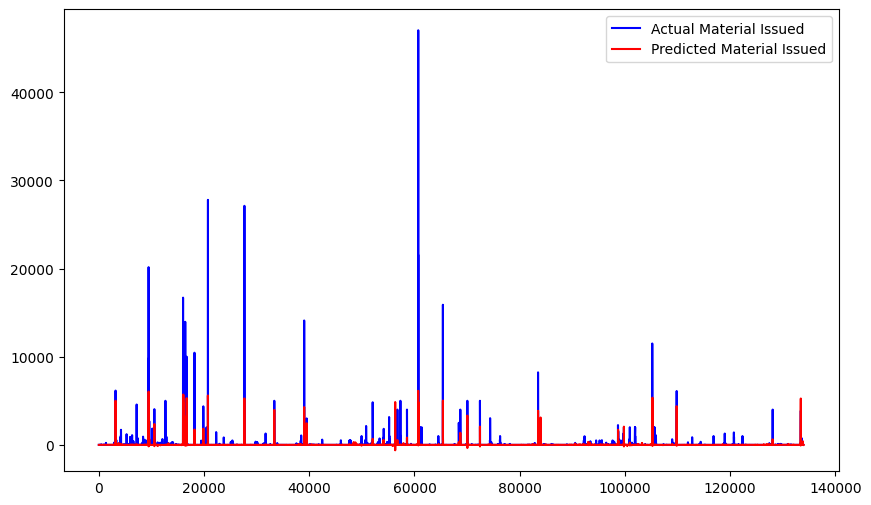

Visualization complete.


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torchviz import make_dot

# Ensure GPU is being used
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and being used.")
else:
    device = torch.device("cpu")
    print("No GPU found. Training will proceed on CPU.")

# Load the dataset in chunks with optimized data types
print("Loading dataset in chunks...")
data_path = '/kaggle/input/inventory/inventory.csv'  # Replace with your Kaggle input path
chunk_size = 50000  # Adjust chunk size for memory optimization

dtypes = {
    'Material Code': 'category',
    'Mateiral Description': 'category',
    'Unit': 'category',
    'Open Stock': 'float32',
    'Material Issued': 'float32',
    'Material Received': 'float32',
    'Closing Stock': 'float32',
    'Prefix': 'category',
    'Type': 'category',
    'PDT': 'float32',
    'BFP': 'float32',
    'Price': 'float32'
}

def preprocess_chunk(chunk):
    # Convert 'Date' to datetime with optimized format
    chunk['Date'] = pd.to_datetime(chunk['Date'])

    # Feature engineering
    chunk['Month'] = chunk['Date'].dt.month
    chunk['Day'] = chunk['Date'].dt.day
    chunk['Day of Week'] = chunk['Date'].dt.dayofweek
    chunk['Is Weekend'] = (chunk['Day of Week'] >= 5).astype('int8')
    chunk['Material Issued'] = chunk['Material Issued'].abs()

    # Sort and calculate rolling features
    chunk.sort_values(by=['Material Code', 'Date'], inplace=True)
    chunk['Rolling_Mean_7'] = (
        chunk.groupby('Material Code', observed=True)['Material Issued']
        .transform(lambda x: x.rolling(window=7, min_periods=1).mean())
    )
    chunk['Rolling_Sum_7'] = (
        chunk.groupby('Material Code', observed=True)['Material Issued']
        .transform(lambda x: x.rolling(window=7, min_periods=1).sum())
    )

    chunk.dropna(inplace=True)
    return chunk

data_chunks = []
for chunk in pd.read_csv(data_path, chunksize=chunk_size, dtype=dtypes):
    processed_chunk = preprocess_chunk(chunk.copy())
    data_chunks.append(processed_chunk)

print("Combining processed chunks...")
data = pd.concat(data_chunks, ignore_index=True)
data = data[data['Type'] == 'Material']

# Feature and target preparation
print("Preparing features and target...")
features = ['Month', 'Day', 'Day of Week', 'Is Weekend', 'Open Stock', 'Material Received', 'Rolling_Mean_7', 'Rolling_Sum_7', 'Material Code', 'BFP']
X = pd.get_dummies(data[features], columns=['Material Code']).to_numpy(dtype=np.float32)
y = data['Material Issued'].to_numpy(dtype=np.float32).reshape(-1, 1)

# Scaling (using StandardScaler)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Create a PyTorch Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, time_steps):
        self.X = X
        self.y = y
        self.time_steps = time_steps

    def __len__(self):
        return len(self.X) - self.time_steps

    def __getitem__(self, idx):
        return (
            torch.tensor(self.X[idx:idx + self.time_steps], dtype=torch.float32),
            torch.tensor(self.y[idx + self.time_steps - 1], dtype=torch.float32)
        )

# Train-validation split
print("Splitting data into train and validation sets...")
split_index = int(len(X_scaled) * 0.8)
X_train, X_val = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_val = y_scaled[:split_index], y_scaled[split_index:]

# Reduce time steps and batch size
time_steps = 5  # Reduced time steps
batch_size = 4  # Reduced batch size

# Create DataLoaders
train_dataset = TimeSeriesDataset(X_train, y_train, time_steps)
val_dataset = TimeSeriesDataset(X_val, y_val, time_steps)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.dropout1(out)
        out, _ = self.lstm2(out)
        out = self.dropout2(out)
        out = self.fc(out[:, -1, :])  # Get output from the last time step
        return out

print("Building LSTM model...")
model = LSTMModel(input_size=X_train.shape[1], hidden_size=8).to(device)

# Visualize the model
dummy_input = torch.randn(batch_size, time_steps, X_train.shape[1]).to(device)
output = model(dummy_input)
dot = make_dot(output, params=dict(model.named_parameters()))
dot.render("lstm_model", format="png")
print("Model visualization saved as 'lstm_model.png'")

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Train the model
print("Starting model training...")
epochs = 10  # Limit epochs initially
train_losses = []  # List to store train losses
val_losses = []  # List to store validation losses

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    model.train()
    epoch_train_loss = 0  # Accumulate train loss for the epoch

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    train_losses.append(epoch_train_loss / len(train_loader))  # Average train loss

    # Validation
    model.eval()
    epoch_val_loss = 0  # Accumulate validation loss for the epoch
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            epoch_val_loss += criterion(outputs, batch_y).item()

    val_losses.append(epoch_val_loss / len(val_loader))  # Average validation loss
    print(f"Validation Loss: {val_losses[-1]}")

print("Model training complete.")

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Save the trained model
print("Saving the model...")
torch.save(model.state_dict(), 'lstm_inventory_model_material_pytorch.pth')
print("Model saved successfully.")

# Evaluate the model
print("Evaluating model...")
model.eval()
val_loss = 0
val_predictions = []
actuals = []
with torch.no_grad():
    for batch_X, batch_y in val_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        val_loss += criterion(outputs, batch_y).item()
        val_predictions.append(outputs.cpu().numpy())
        actuals.append(batch_y.cpu().numpy())

val_loss /= len(val_loader)
print(f"Validation Loss: {val_loss}")

# Concatenate predictions and actuals
val_predictions = np.vstack(val_predictions)
actuals = np.vstack(actuals)

# Rescale predictions and actual values
print("Rescaling predictions and actual values...")
val_predictions_rescaled = scaler_y.inverse_transform(val_predictions)
actuals_rescaled = scaler_y.inverse_transform(actuals)

# Visualize predictions vs actual
print("Visualizing results...")
plt.figure(figsize=(10, 6))
plt.plot(actuals_rescaled, label='Actual Material Issued', color='blue')
plt.plot(val_predictions_rescaled, label='Predicted Material Issued', color='red')
plt.legend()
plt.show()
print("Visualization complete.")
